In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d datamunge/sign-language-mnist
!unzip ./sign-language-mnist.zip

 80% 50.0M/62.6M [00:01<00:00, 20.7MB/s]
100% 62.6M/62.6M [00:01<00:00, 41.9MB/s]
Archive:  ./sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import Conv2D, BatchNormalization, Activation, Dropout
# from keras.layers import MaxPooling2D
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam, SGD, RMSprop
# from keras.activations import relu, elu
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
plt.rcParams['font.size'] = 12
plt.rcParams['lines.color'] ='#000000'
np.random.seed(1234567)

In [23]:
train_path = './sign_mnist_train/sign_mnist_train.csv'
test_path = './sign_mnist_test/sign_mnist_test.csv'

In [24]:
train = pd.read_csv(train_path) # import data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [25]:
print('shape of training data:', train.shape) # (nrow, ncolumn)

''' na count over all rows and columns
first sum = sums over rows, last sum = sums over columns
'''
print('na count:', train.isna().sum().sum())

shape of training data: (27455, 785)
na count: 0


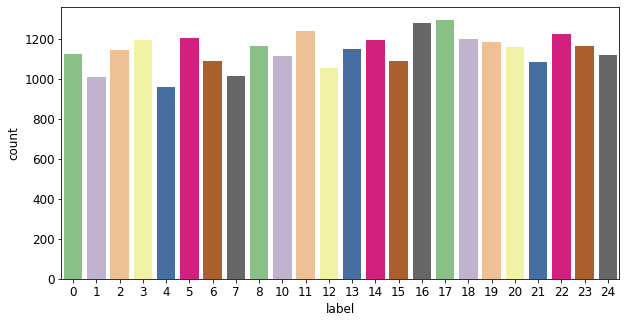

In [26]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=train, palette='Accent')
plt.show()

In [27]:
target_counts = train['label'].value_counts()
target_counts = round(target_counts * 100 / target_counts.sum())
print('majority : minority class ratio =', target_counts.max(), ':', target_counts.min())

majority : minority class ratio = 5.0 : 3.0


In [28]:
X = train.drop('label', axis=1) # features
y = keras.utils.to_categorical(train['label']) # encode target

In [29]:
# reshape square black and white images
def reshape_bw(X):
    samples, width, channel = X.shape[0], int(X.shape[1] ** (1/2)) , 1
    return X.values.reshape(samples, width, width, channel)  

In [30]:
X = reshape_bw(X)
width, height, channel = X.shape[1], X.shape[2], X.shape[3]

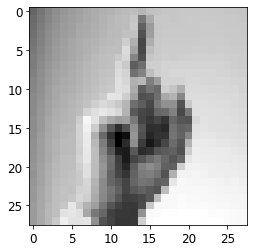

In [31]:
# plot a square black and white image
def plot_image(X, width):
    _ = plt.imshow(X.reshape(width, width), cmap='gray')
    plt.show()
    
plot_image(X[0], width) # plot sample image

In [32]:
# split data into train and validation set with same target distribution as before spliting
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [33]:
# create data preprocessor and fit on train set
generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    height_shift_range=0.15,
    width_shift_range=0.15, 
    fill_mode='nearest'
)
generator.fit(X_train)

In [49]:
# initialize model
def build_baseline_model(func, init):
    keras.backend.clear_session()
    inputs = keras.Input(shape=tuple(X_train.shape[1:]))
    inter = keras.layers.Conv2D(64, (5, 5), padding="same", kernel_initializer=init(), input_shape=(width, height, channel))(inputs)
    inter = keras.layers.BatchNormalization()(inter)
    inter = keras.layers.Activation(func)(inter)
    inter = keras.layers.MaxPooling2D((2, 2))(inter)
    inter = keras.layers.Conv2D(128, (5, 5), padding="same", kernel_initializer=init())(inter)
    inter = keras.layers.BatchNormalization()(inter)
    inter = keras.layers.Activation(func)(inter)
    inter = keras.layers.MaxPooling2D((2, 2))(inter)
    inter = keras.layers.Conv2D(256, (5, 5), padding="same", kernel_initializer=init())(inter)
    inter = keras.layers.BatchNormalization()(inter)
    inter = keras.layers.Activation(func)(inter)
    inter = keras.layers.MaxPooling2D((2, 2))(inter)
    inter = keras.layers.Flatten()(inter)
    outputs = keras.layers.Dense(y.shape[1], activation='softmax')(inter)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

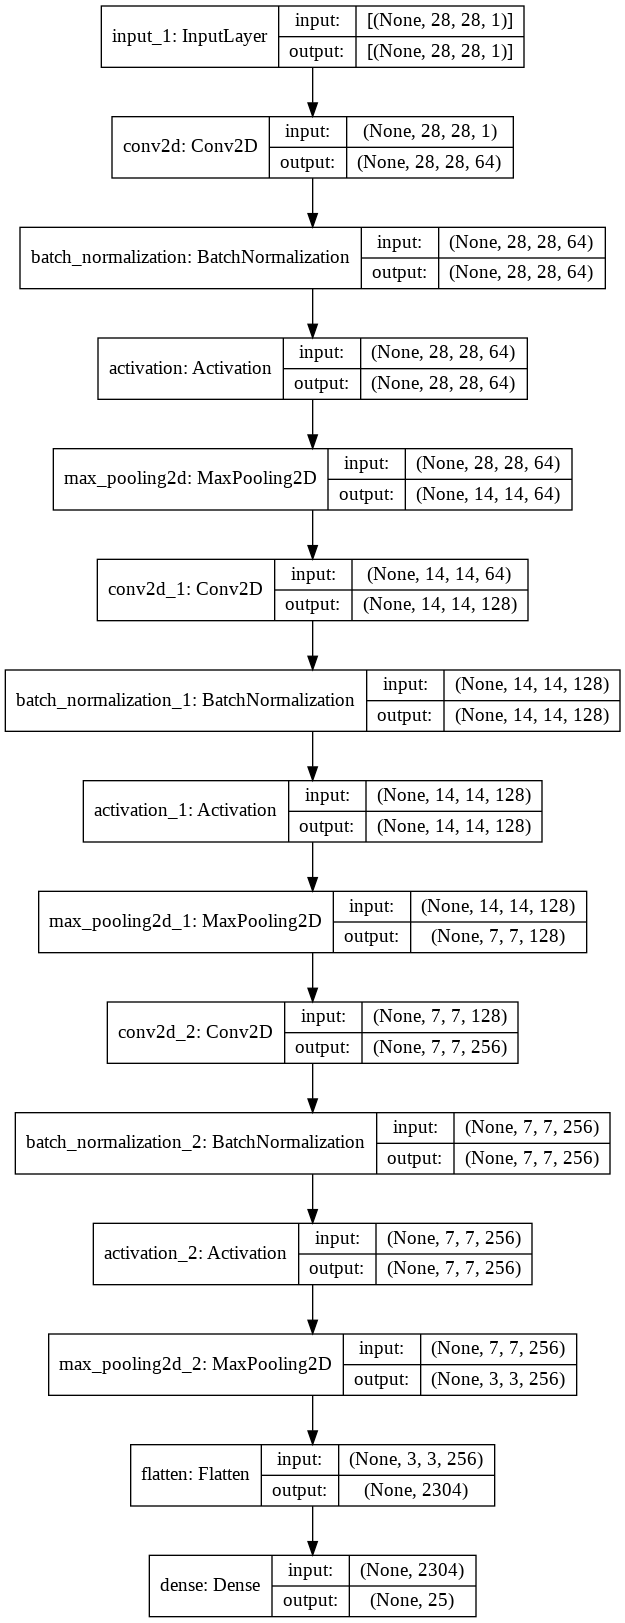

In [51]:
model_elu = build_baseline_model(keras.activations.elu, keras.initializers.glorot_uniform)
# compile model
model_elu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.006),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)
keras.utils.plot_model(model_elu, "model_elu_base.png", show_shapes=True)

In [52]:
# deine model callnbak
cb_elu = [keras.callbacks.ModelCheckpoint('model_elu_base.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [53]:
history_elu = model_elu.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=25, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_elu,
                    verbose=2)

Epoch 1/25
687/687 - 48s - loss: 1.1873 - accuracy: 0.7037 - precision: 0.7910 - recall: 0.6605 - auc: 0.9575 - val_loss: 0.2266 - val_accuracy: 0.9248 - val_precision: 0.9403 - val_recall: 0.9142 - val_auc: 0.9972
Epoch 2/25
687/687 - 16s - loss: 0.1487 - accuracy: 0.9523 - precision: 0.9577 - recall: 0.9473 - auc: 0.9980 - val_loss: 0.0516 - val_accuracy: 0.9832 - val_precision: 0.9852 - val_recall: 0.9814 - val_auc: 0.9997
Epoch 3/25
687/687 - 16s - loss: 0.0893 - accuracy: 0.9731 - precision: 0.9756 - recall: 0.9713 - auc: 0.9984 - val_loss: 0.1627 - val_accuracy: 0.9528 - val_precision: 0.9551 - val_recall: 0.9494 - val_auc: 0.9957
Epoch 4/25
687/687 - 16s - loss: 0.0845 - accuracy: 0.9759 - precision: 0.9775 - recall: 0.9745 - auc: 0.9981 - val_loss: 0.0679 - val_accuracy: 0.9816 - val_precision: 0.9820 - val_recall: 0.9812 - val_auc: 0.9985
Epoch 5/25
687/687 - 16s - loss: 0.0095 - accuracy: 0.9972 - precision: 0.9973 - recall: 0.9969 - auc: 0.9999 - val_loss: 0.0036 - val_accur

In [67]:
def plot_learning_curve(history):
    ephs = np.arange(0, len(history.history['loss'])) + 1
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(ephs, history.history['accuracy'], '--')
    plt.plot(ephs, history.history['val_accuracy'], '--')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.subplot(1,2,2)
    plt.plot(ephs, history.history['loss'], '--')
    plt.plot(ephs, history.history['val_loss'], '--')
    plt.legend(['loss', 'val_loss'])
    plt.show()

learning curve of baseline model


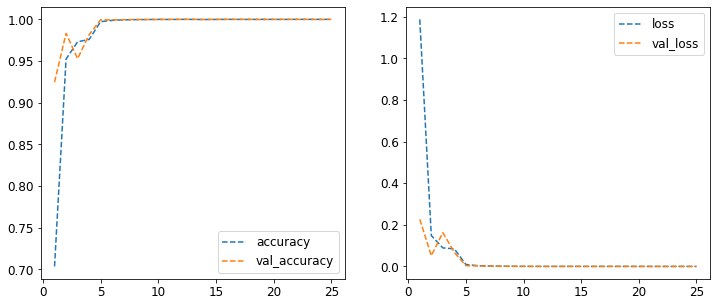

In [68]:
print(f"learning curve of baseline model")
plot_learning_curve(history_elu)

baseline model starts converging at 5th epoch

In [69]:
# evaluate model on unseen data
test = pd.read_csv(test_path)
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


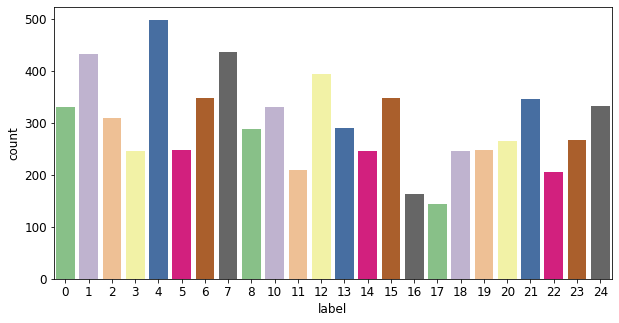

In [70]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=test, palette='Accent')
plt.show()

In [71]:
X_test = test.drop('label', axis=1)
y_test = test['label']
X_test = reshape_bw(X_test)
y_test = to_categorical(y_test)

In [78]:
def evaluate(model):
    loss, acc, pre, rec, auc = model.evaluate(generator.flow(X_test,y_test,batch_size=32))
    print()
    print(f"test loss: {loss}")
    print(f"test accuracy: {round(acc*100,2)} %")
    print(f"test precision: {pre}")
    print(f"test recall: {rec}")
    print(f"test AUC: {auc}")
    print()
    index = int(input("Enter image index: ")) % X_test.shape[0]
    print(f"label: {np.argmax(model.predict(np.expand_dims([X_test[index]], axis=-1), verbose=0))}")
    print(f"actual label: {np.argmax(y_test[index], axis=-1)}")
    plot_image(X_test[index], width)

evaluating baseline model
225/225 [==============================] - 4s 20ms/step - loss: 0.0171 - accuracy: 0.9950 - precision: 0.9957 - recall: 0.9950 - auc: 0.9997

test loss: 0.017135005444288254
test accuracy: 99.5 %
test precision: 0.9956746101379395
test recall: 0.9949804544448853
test AUC: 0.9997112154960632

Enter image index: 1000
label: 3
actual label: 3


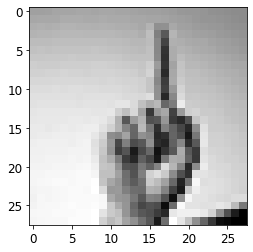

In [79]:
print(f"evaluating baseline model")
evaluate(model_elu)

In [80]:
from sklearn.metrics import confusion_matrix
def plot_confmat(model):   
    cm = confusion_matrix(test['label'], model.predict(X_test).argmax(-1))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap=plt.cm.Purples)
    plt.ylabel('actual')
    plt.xlabel('predicted')
    plt.show()

confusion matrix of baseline model


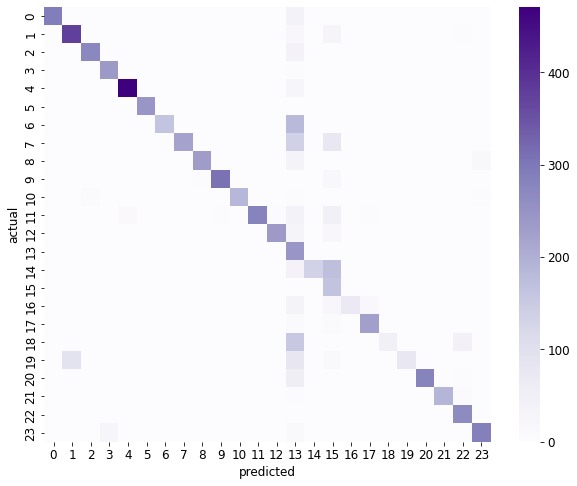

In [81]:
print(f"confusion matrix of baseline model")
plot_confmat(model_elu)

test examples are mostly missclassified to class 13, the overall performance is moderately good

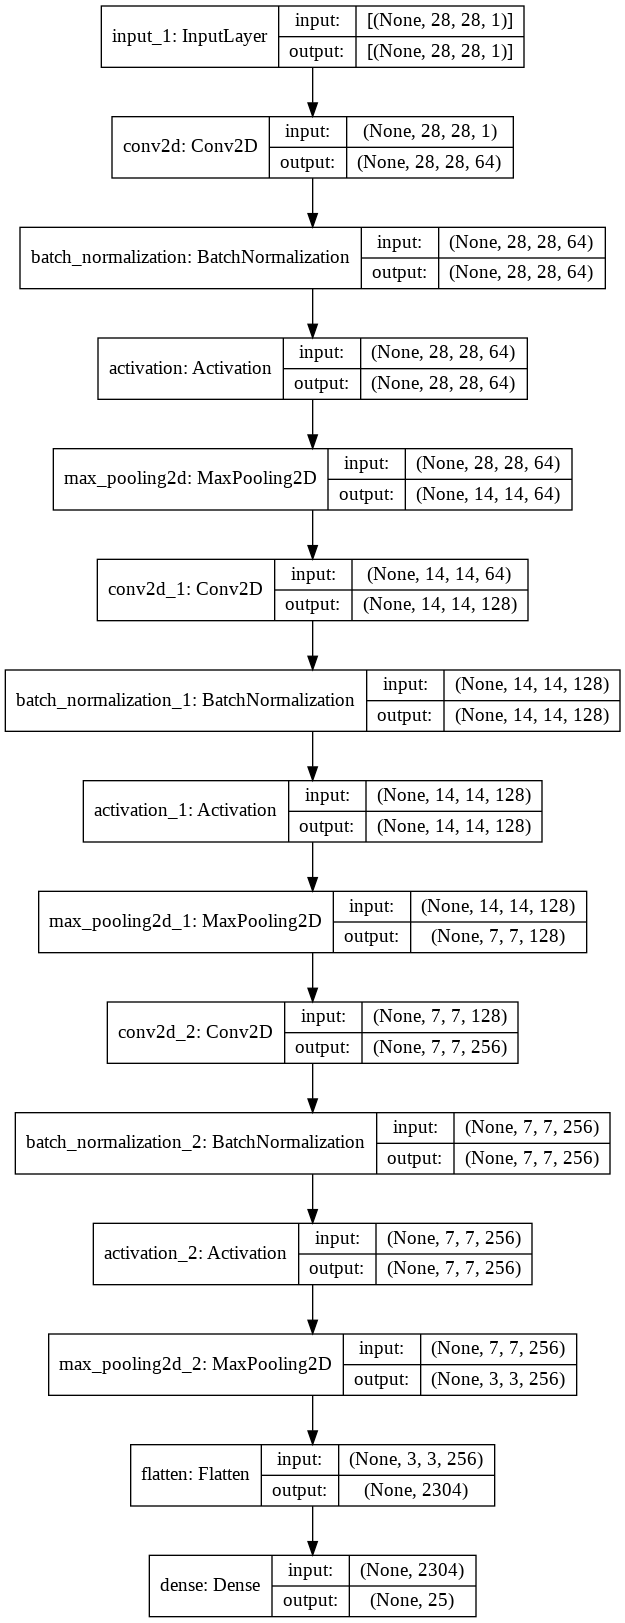

In [82]:
model_elu_2 = build_baseline_model(keras.activations.elu, keras.initializers.he_uniform)
# compile model
model_elu_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.006),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)
keras.utils.plot_model(model_elu_2, "model_elu2_base.png", show_shapes=True)

In [83]:
cb_elu_2 = [keras.callbacks.ModelCheckpoint('model_elu2_base.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [84]:
history_elu_2 = model_elu_2.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=25, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_elu_2,
                    verbose=2)

Epoch 1/25
687/687 - 18s - loss: 1.1523 - accuracy: 0.7279 - precision: 0.8219 - recall: 0.6862 - auc: 0.9577 - val_loss: 0.1965 - val_accuracy: 0.9364 - val_precision: 0.9455 - val_recall: 0.9281 - val_auc: 0.9965
Epoch 2/25
687/687 - 16s - loss: 0.1206 - accuracy: 0.9626 - precision: 0.9669 - recall: 0.9583 - auc: 0.9981 - val_loss: 0.4098 - val_accuracy: 0.9078 - val_precision: 0.9146 - val_recall: 0.9027 - val_auc: 0.9854
Epoch 3/25
687/687 - 16s - loss: 0.0928 - accuracy: 0.9717 - precision: 0.9741 - recall: 0.9703 - auc: 0.9982 - val_loss: 0.0716 - val_accuracy: 0.9771 - val_precision: 0.9802 - val_recall: 0.9754 - val_auc: 0.9984
Epoch 4/25
687/687 - 16s - loss: 0.0567 - accuracy: 0.9820 - precision: 0.9833 - recall: 0.9810 - auc: 0.9988 - val_loss: 0.1244 - val_accuracy: 0.9636 - val_precision: 0.9655 - val_recall: 0.9625 - val_auc: 0.9968
Epoch 5/25
687/687 - 16s - loss: 0.0921 - accuracy: 0.9764 - precision: 0.9775 - recall: 0.9757 - auc: 0.9977 - val_loss: 0.1826 - val_accur

learning curve of model with he uniform initializer


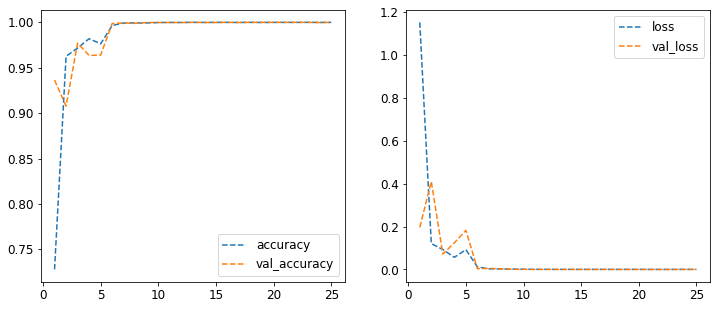

In [85]:
print(f"learning curve of model with he uniform initializer")
plot_learning_curve(history_elu_2)

glorot uniform converge earlier that he uniform

evaluating model with he uniform initializer
225/225 [==============================] - 4s 19ms/step - loss: 0.0147 - accuracy: 0.9951 - precision: 0.9954 - recall: 0.9951 - auc: 0.9999

test loss: 0.014671001583337784
test accuracy: 99.51 %
test precision: 0.9953975081443787
test recall: 0.9951199293136597
test AUC: 0.999926745891571

Enter image index: 1234
label: 4
actual label: 4


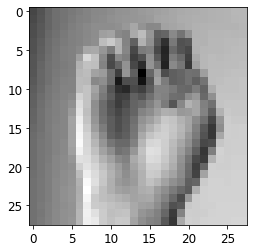

In [87]:
print(f"evaluating model with he uniform initializer")
evaluate(model_elu_2)

confusion matrix of model with he uniform initializer


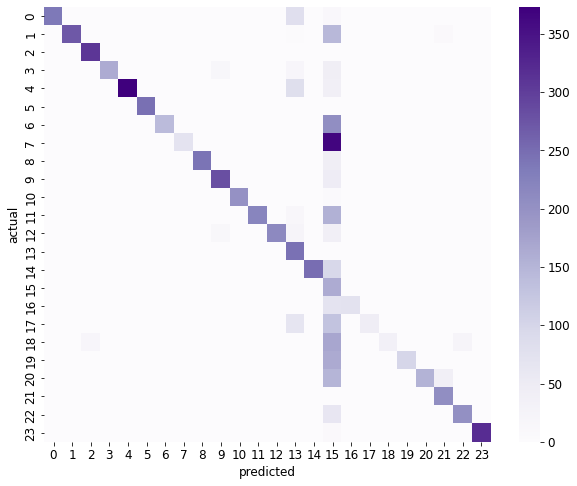

In [89]:
print(f"confusion matrix of model with he uniform initializer")
plot_confmat(model_elu_2)

test examples are mostly missclassified to class 15, he uniform performed better than glorot uniform in overall

for this dataset, model with glorot uniform initializer should be choosen as less test examples are missclassified per class